In [26]:
import torch
import torchvision
from torchvision import transforms
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader,Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
import os
import skimage.data as imd
from skimage import transform 
%matplotlib inline

In [38]:
def load_my_data(directory):
    labels = []
    images = []
    images_dirs = [os.path.join(directory,f) for f in os.listdir(directory) if f.endswith(".jpg") ]
    for f in images_dirs:
        images.append(imd.imread(f))
        labels.append(f)
    return  images,labels

In [39]:
images,labels = load_my_data("sample")

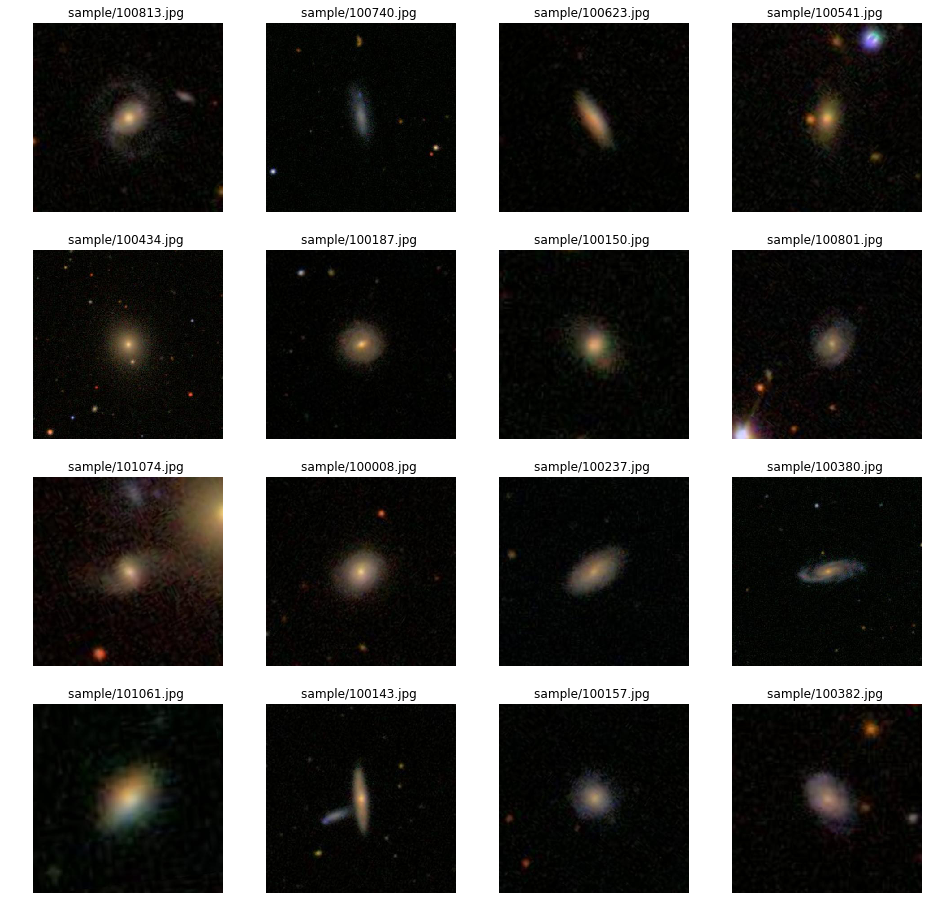

In [40]:
plt.figure(figsize=(16,16))
for i in range(16):
    temp_im = images[i]
    plt.subplot(4,4,i+1)
    plt.axis("off")
    plt.title("{} ".format(labels[i]))
    plt.imshow(temp_im)
plt.show()

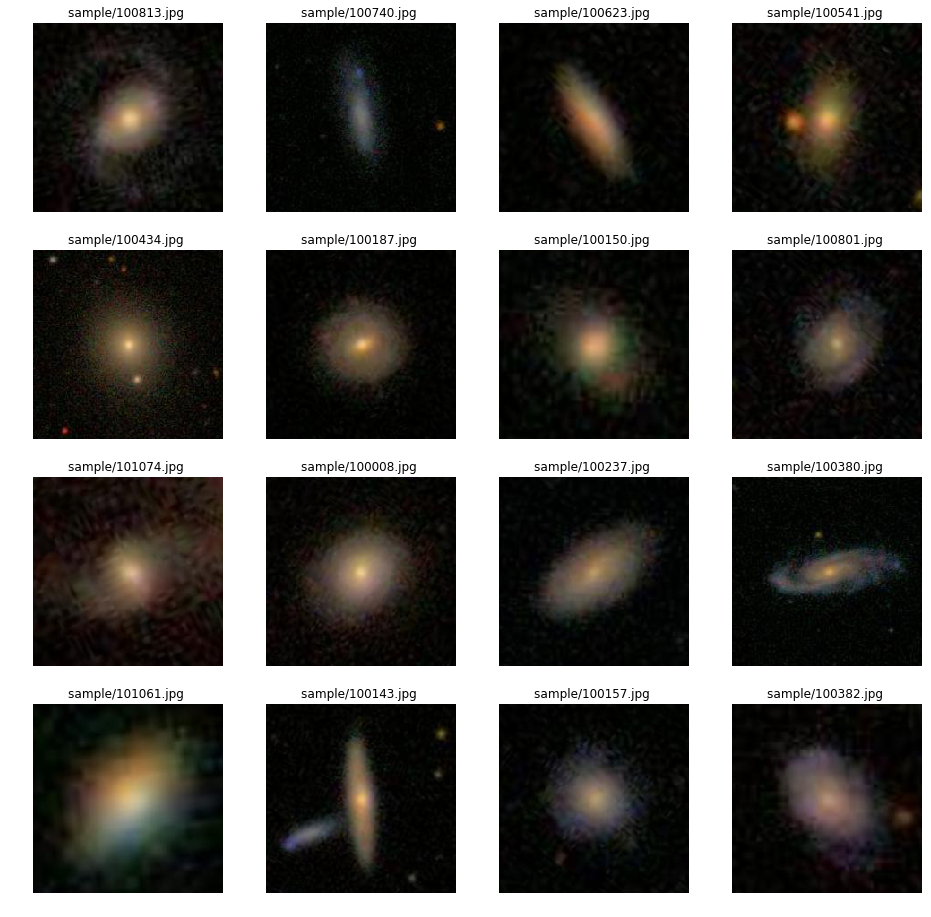

In [41]:
plt.figure(figsize=(16,16))
for i in range(16):
    temp_im = images[i]
    plt.subplot(4,4,i+1)
    plt.axis("off")
    plt.title("{} ".format(labels[i]))
    plt.imshow(temp_im[106:106*3,106:106*3])
plt.show()

In [35]:
class GalaxyDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.data = pd.read_csv(csv_file)
        self.len = self.data.shape[0]
        self.transform = transform
    
    def __getitem__(self,index):
        img_name = os.path.join(self.root_dir,
                                str(self.data.iloc[index, 0])+".jpg")
        image = Image.open(img_name,'r')
        labels = self.data.iloc[index,1:].values
        labels = torch.from_numpy(labels)
        ids = self.data.iloc[index,0]
        
        if self.transform:
            image = self.transform(image)
        return image,labels,ids
        
    def __len__(self):
        return self.len
        

In [41]:
batch_size = 100
valid_size = 0.2

compose1 = transforms.Compose([transforms.CenterCrop(128),
                              transforms.Resize(64),
                              transforms.ToTensor(),
                              transforms.Normalize([0.5,0.5,0.5],
                                                   [0.5,0.5,0.5])])

compose2 = transforms.Compose([transforms.CenterCrop(128),
                              transforms.Resize(64),
                              transforms.ToTensor(),
                              transforms.Normalize([0.5,0.5,0.5],
                                                   [0.5,0.5,0.5])])

dataset_train = GalaxyDataset("all/training_solutions_rev1.csv","all/images_training_rev1",transform= compose1)
dataset_test = GalaxyDataset("all/central_pixel_benchmark.csv","all/images_training_rev1",transform= compose2)

num_train = len(dataset_train)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx,valid_idx = indices[split:],indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(dataset=dataset_train,batch_size=batch_size, sampler = train_sampler,num_workers=2)
eval_loader = DataLoader(dataset=dataset_train,batch_size=batch_size, sampler = valid_sampler,num_workers=2)
test_loader = DataLoader(dataset=dataset_test,batch_size=batch_size,num_workers=2)

In [53]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_3_32 = torch.nn.Conv2d(3,32,kernel_size= 5,stride=1,padding= 2)
        self.conv_32_16 = torch.nn.Conv2d(32,16,kernel_size= 5,stride=1,padding= 2)
        self.conv_16_8 = torch.nn.Conv2d(16,8,kernel_size= 5,stride=1,padding= 2)
        self.maxpool_2_2 = torch.nn.MaxPool2d(kernel_size= 2, stride = 2)
        self.fc_512_256 = torch.nn.Linear(512,256)
        self.fc_256_128 = torch.nn.Linear(256,256)
        self.fc_64_37 = torch.nn.Linear(256,37)
        self.dropout = torch.nn.Dropout(p=0.2)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self,x):
        self.orig = x
        x = self.maxpool_2_2(F.relu(self.conv_3_32(x)))
        self.result1 = x
        x = self.maxpool_2_2(F.relu(self.conv_32_16(x)))
        self.result2 = x
        x = self.maxpool_2_2(F.relu(self.conv_16_8(x)))
        self.result3 = x
        x = x.view(x.shape[0],-1)
        x = self.dropout(F.relu(self.fc_512_256(x)))
        x = self.dropout(F.relu(self.fc_256_128(x)))
        x = self.sigmoid(self.fc_64_37(x))
        return x

In [54]:
model = Model()
model

Model(
  (conv_3_32): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv_32_16): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv_16_8): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool_2_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_512_256): Linear(in_features=512, out_features=256, bias=True)
  (fc_256_128): Linear(in_features=256, out_features=256, bias=True)
  (fc_128_64): Linear(in_features=256, out_features=128, bias=True)
  (fc_64_37): Linear(in_features=256, out_features=37, bias=True)
  (dropout): Dropout(p=0.2)
  (sigmoid): Sigmoid()
)

In [7]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
  model.cuda()
  print("running on GPU")
else:
  print("GPU not available")

GPU not available


In [0]:
epochs = 30
valid_loss_min = np.Inf
losses= []
for epoch in range(epochs):
    train_loss = 0
    valid_loss = 0
    
    model.train()
    for img,labels,ids in train_loader:
        if train_on_gpu:
            img,labels = Variable(img).cuda(),Variable(labels).cuda()
        optimizer.zero_grad()
        out = model(img)
        loss = torch.sqrt(criterion(out,labels.type(torch.cuda.FloatTensor)))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    model.eval()
    with torch.no_grad():
        for img,labels,ids in eval_loader:
            if train_on_gpu:
                img,labels = Variable(img).cuda(),Variable(labels).cuda()
            out = model(img)
            loss = torch.sqrt(criterion(out,labels.type(torch.cuda.FloatTensor)))
            valid_loss += loss.item()
            
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(eval_loader)
    losses.append([train_loss,valid_loss])
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 0 	Training Loss: 0.148408 	Validation Loss: 0.127602
Validation loss decreased (inf --> 0.127602).  Saving model ...
Epoch: 1 	Training Loss: 0.126388 	Validation Loss: 0.119251
Validation loss decreased (0.127602 --> 0.119251).  Saving model ...
Epoch: 2 	Training Loss: 0.117662 	Validation Loss: 0.111236
Validation loss decreased (0.119251 --> 0.111236).  Saving model ...
Epoch: 3 	Training Loss: 0.112113 	Validation Loss: 0.109605
Validation loss decreased (0.111236 --> 0.109605).  Saving model ...
Epoch: 4 	Training Loss: 0.107614 	Validation Loss: 0.106111
Validation loss decreased (0.109605 --> 0.106111).  Saving model ...
Epoch: 5 	Training Loss: 0.104408 	Validation Loss: 0.103681
Validation loss decreased (0.106111 --> 0.103681).  Saving model ...
Epoch: 6 	Training Loss: 0.101806 	Validation Loss: 0.102386
Validation loss decreased (0.103681 --> 0.102386).  Saving model ...
Epoch: 7 	Training Loss: 0.099553 	Validation Loss: 0.102125
Validation loss decreased (0.10238

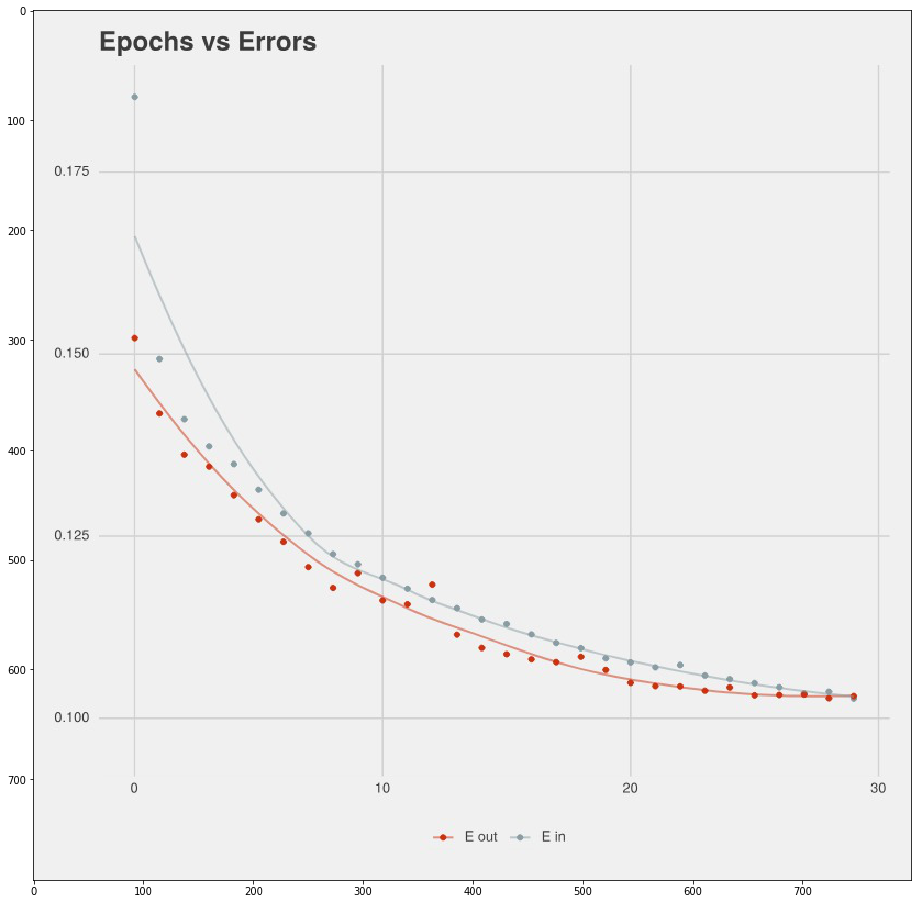

In [69]:
grph = Image.open("graph.jpeg")
plt.figure(figsize=(16,16))

plt.imshow(grph)

In [55]:
model.load_state_dict(torch.load('model_cifar_1034.pt', map_location=lambda storage, loc: storage))

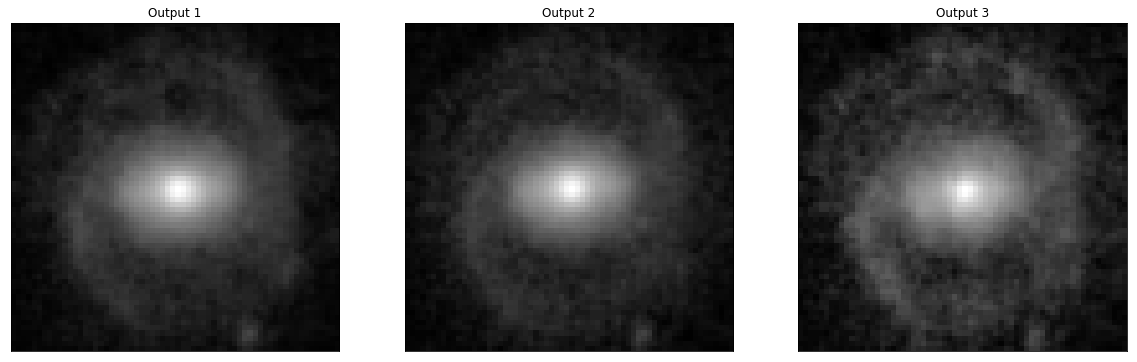

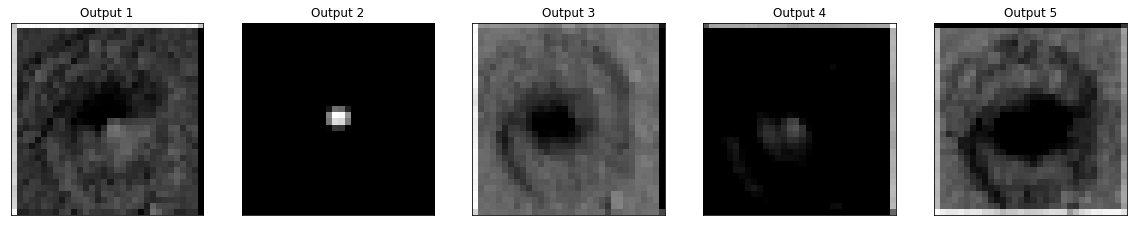

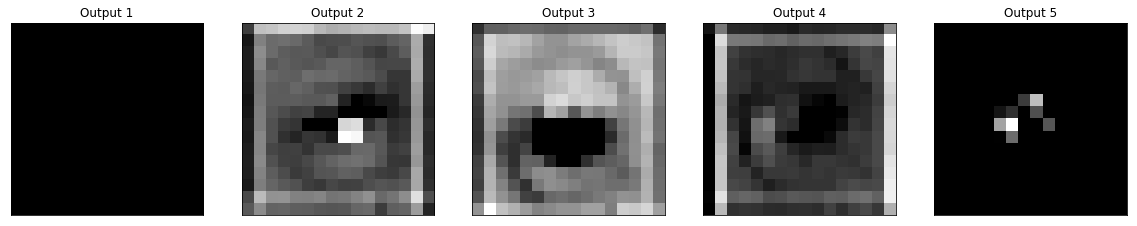

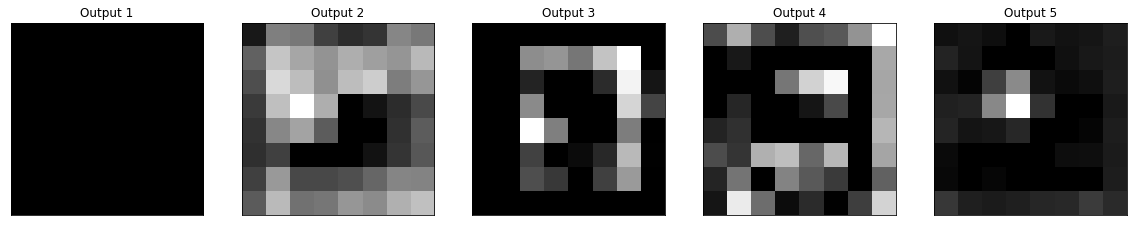

In [58]:
def viz_layer(layer, n_filters= 4):
    fig = plt.figure(figsize=(20, 20))
    
    for i in range(n_filters):
        ax = fig.add_subplot(1, n_filters, i+1, xticks=[], yticks=[])
        # grab layer outputs
        ax.imshow(np.squeeze(layer[0,i].data.numpy()), cmap='gray')
        ax.set_title('Output %s' % str(i+1))

itera = iter(train_loader)
image,label,ids = next(itera)
with torch.no_grad():
    output = model(image)

orig = model.orig
filter1 = model.result1
filter2 = model.result2
filter3 = model.result3

viz_layer(orig,n_filters=3)
viz_layer(filter1,n_filters=5)
viz_layer(filter2,n_filters= 5)
viz_layer(filter3,n_filters= 5)

In [0]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
header = open('all_zeros_benchmark.csv','r').readlines()[0]
with open('submission_1.csv','w') as outfile:
    outfile.write(header)
    for data, target,ids in test_loader:
        if train_on_gpu:
            data, target = Variable(data).cuda(), Variable(target).cuda()
        output = model(data)
        entry=""
        for i in range(len(output)):
          entry += "{},{}\n".format(ids[i],",".join([str(x.item()) for x in output[i]]))
        outfile.write(entry)
          
    #loss = torch.sqrt(criterion(output, target.type(torch.cuda.FloatTensor)))
    #test_loss += loss.item()*data.size(0)

#test_loss = test_loss/len(test_loader.dataset)
#print('Test Loss: {:.6f}\n'.format(test_loss))
